(c) 2023 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [25]:
# Load project package
@load_pkg BayesFitness

import Revise
# Import project package
import BayesFitness
# Import library to list files
import Glob

# Import package to handle DataFrames
import DataFrames as DF
import CSV
import XLSX

# Import basic statistical functions
import StatsBase
import Random

# Import basic math
import LinearAlgebra

# Import libraries relevant for MCMC
import Turing
import MCMCChains

# Load CairoMakie for plotting
using CairoMakie
import ColorSchemes
import Makie
# Activate backend
CairoMakie.activate!()

# Set PBoC Plotting style
BayesFitness.viz.pboc_makie!()

# Bayesian inference of the mean fitness

In this notebook, we perform Bayesian inference on the mean fitness of a yeast
population based on the frequency change of barcoded neutral strains.

## The fitness model

`[explanation here]`

## Non-Bayesian data normalization

Before implementing the full Bayesian model, let's explore the data. We will
take a look at what the frequency changes look like with and without the
normalization by the neutrals.

First, let's load the data.

In [2]:
# Load data
df = CSV.read("$(git_root())/data/big_batch/tidy_counts.csv", DF.DataFrame)

first(df, 5)

Row,BCID_x,bc_merged,barcode,barcode_lowcomplexity,barcode_highcomplexity,BCID_y,barcode_fasta,source_publication,cloneID,cloneID_new,evolution_condition,ancestor,class,ploidy,ploidy_new,gene,type,additional_muts,1D_Fitness_Li2019,1D_Error_Li2019,2D_Fitness_Li2019,2D_Error_Li2019,3D_Fitness_Li2019,3D_Error_Li2019,5D_Fitness_Li2019,5D_Error_Li2019,FerPerHour_Li2019,ResPerHour_Li2019,StaPerHour_Li2019,name,count,rep,timepoint,time,batch,hub,perturbation,neutral
,Int64,String,String,String31,String,Int64,String,String15,String31,String?,String7,String15,String31,String15,String15,String31,String?,String?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,String,Int64,String3,String3,Int64,String7,String7,String15,Bool
1,0,GAGTGAAACATGAATGGTATTCATCATGATCAATCTACAAAAATATTTAATG,TGATCAATCTACAAAAATATTTAATG_GAGTGAAACATGAATGGTATTCATCA,TGATCAATCTACAAAAATATTTAATG,GAGTGAAACATGAATGGTATTCATCA,0,GAGTGAAACATGAATGGTATTCATCATGATCAATCTACAAAAATATTTAATG,This_study,missing,EVO2D_IRA1_MIS_rearray_Plate1-A1,Evo2D,IRA1_MIS,missing,missing,diploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,53,R0,T0,0,Batch1,1Day,None,false
2,1,ACTCTAACGTGTAACTAATTTTGAGTCCGCCAATCCCGAACCCCGTTTCGCC,CCGCCAATCCCGAACCCCGTTTCGCC_ACTCTAACGTGTAACTAATTTTGAGT,CCGCCAATCCCGAACCCCGTTTCGCC,ACTCTAACGTGTAACTAATTTTGAGT,1,ACTCTAACGTGTAACTAATTTTGAGTCCGCCAATCCCGAACCCCGTTTCGCC,Aggeli2020,gpb2_evo1_plate9_H8,gpb2_evo1_plate9_H8,Evo2D,GPB2,adaptive_haploids,Haploid,Haploid,missing,Other,DOP1-NON_SYNONYMOUS_CODING; SMD2-NON_SYNONYMOUS_CODING; YDL180W-DOWNSTREAM; LAS21-UPSTREAM,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,1213,R0,T0,0,Batch1,1Day,None,false
3,2,ATGGGAACACGGAATGATCTTTTATTGACAGAAAAGCCAAATGGATTTACCG,GACAGAAAAGCCAAATGGATTTACCG_ATGGGAACACGGAATGATCTTTTATT,GACAGAAAAGCCAAATGGATTTACCG,ATGGGAACACGGAATGATCTTTTATT,2,ATGGGAACACGGAATGATCTTTTATTGACAGAAAAGCCAAATGGATTTACCG,This_study,missing,EVO3D_TCG_rearray_Plate1-A4,Evo3D,CYR1,missing,missing,diploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,17,R0,T0,0,Batch1,1Day,None,false
4,3,TACTAAATAAGTAAGGGAATTCTGTTCCAACAAAACACAAATCTGTTGTGTA,CCAACAAAACACAAATCTGTTGTGTA_TACTAAATAAGTAAGGGAATTCTGTT,CCAACAAAACACAAATCTGTTGTGTA,TACTAAATAAGTAAGGGAATTCTGTT,3,TACTAAATAAGTAAGGGAATTCTGTTCCAACAAAACACAAATCTGTTGTGTA,This_study,missing,EVO2D_IRA1_NON_rearray_Plate1-A1,Evo2D,IRA1_NON,missing,missing,diploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,19,R0,T0,0,Batch1,1Day,None,false
5,4,ATGACAAACTTTAAATAATTTAATTGTATCGAAACCCAAAGAGATTTAATCG,TATCGAAACCCAAAGAGATTTAATCG_ATGACAAACTTTAAATAATTTAATTG,TATCGAAACCCAAAGAGATTTAATCG,ATGACAAACTTTAAATAATTTAATTG,4,ATGACAAACTTTAAATAATTTAATTGTATCGAAACCCAAAGAGATTTAATCG,This_study,missing,EVO3D_IRA1_MIS_rearray_Plate1-C4,Evo3D,IRA1_MIS,missing,missing,haploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,23,R0,T0,0,Batch1,1Day,None,false


Let's plot some of the barcode trajectories. We will highlight the neutral
lineages with darker lines.

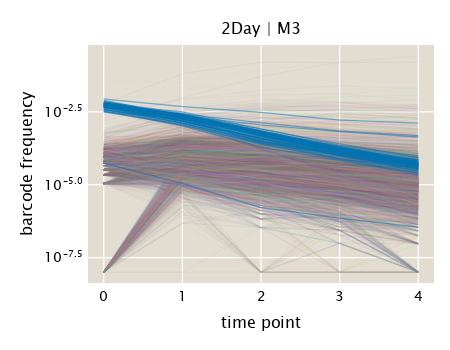

In [3]:
Random.seed!(42)

# Define information for data to extract
# Define batch
batch = "Batch4"
hub = "2Day"
perturbation = "M3"
rep = "R1"

# Extract data. Note: The time T0 is common to all perturbations, thus, it must
# be extracted separately as a second condition.
data = df[
        (df.hub .== hub) .& 
        (df.batch .== batch) .&
        (
            (df.perturbation .== perturbation) .| 
            (df.perturbation .== "None")
        ) .&
        (
            (df.rep .== rep) .| 
            (df.rep .== "R0")
        )
    ,
:]

# Extract total counts per barcode
data_total = DF.combine(DF.groupby(data, :time), :count => sum)
# Extract total counts per barcode
data_total = DF.combine(DF.groupby(data, :time), :count => sum)
# Add total count column to dataframe
DF.leftjoin!(data, data_total; on=:time)
# Add frequency column
DF.insertcols!(data, :freq => data.count ./ data.count_sum)

# Initialize figure
fig = Figure(resolution=(450, 350))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="time point",
    ylabel="barcode frequency",
    yscale=log10,
    title="$(hub) | $(perturbation)"
)

# Define color palette
colors = ColorSchemes.glasbey_hv_n256

# group data by barcode
data_group = DF.groupby(data[.!data.neutral, :], :barcode)
# Loop through trajectories
for bc in data_group
    # Plot trajectory
    lines!(
        bc.time, 
        bc.freq .+ 1E-8,
        color=(colors[StatsBase.sample(1:length(colors))], 0.05)
    )
end # for

# group neutral barcodes by barcode
data_group = DF.groupby(data[data.neutral, :], :barcode)
# Loop through trajectories
for bc in data_group
    # Plot trajectory
    lines!(
        bc.time, 
        bc.count ./ data_total.count_sum .+ 1E-8,
        color=(ColorSchemes.seaborn_colorblind[1], 0.5)
    )
end # for

fig

Now, let's plot the finite differences in the log frequencies vs time. In other
words, the $y$-axis will now represent $\log(f_{t+1}/f_{t})$.

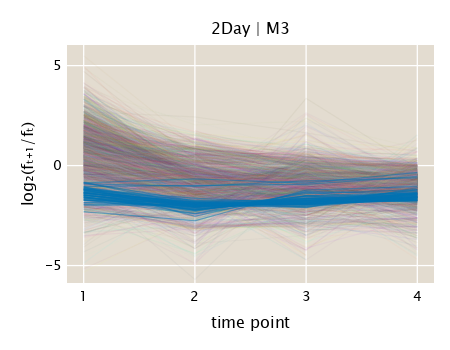

In [18]:
Random.seed!(42)

# Define information for data to extract
# Define batch
batch = "Batch4"
hub = "2Day"
perturbation = "M3"
rep = "R1"

# Extract data. Note: The time T0 is common to all perturbations, thus, it must
# be extracted separately as a second condition.
data = df[
        (df.hub .== hub) .& 
        (df.batch .== batch) .&
        (
            (df.perturbation .== perturbation) .| 
            (df.perturbation .== "None")
        ) .&
        (
            (df.rep .== rep) .| 
            (df.rep .== "R0")
        )
    ,
:]

# Extract total counts per barcode
data_total = DF.combine(DF.groupby(data, :time), :count => sum)
# Extract total counts per barcode
data_total = DF.combine(DF.groupby(data, :time), :count => sum)
# Add total count column to dataframe
DF.leftjoin!(data, data_total; on=:time)
# Add frequency column
DF.insertcols!(data, :freq => data.count ./ data.count_sum)

# Initialize dataframe to save the log freq changes
data_log = DF.DataFrame()

# Group data by barcode
data_group = DF.groupby(data, :barcode)

# Loop through each group
for d in data_group
    # Compute log change
    DF.append!(
        data_log, 
        DF.DataFrame(
            :barcode .=> first(d.barcode),
            :time => d.time[2:end],
            :logf => diff(log2.(d.freq)),
            :neutral .=> first(d.neutral)
        )
    )
end # for

# Initialize figure
fig = Figure(resolution=(450, 350))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="time point",
    ylabel="log₂(fₜ₊₁/fₜ)",
    title="$(hub) | $(perturbation)"
)

# Define color palette
colors = ColorSchemes.glasbey_hv_n256

# group data by barcode
data_group = DF.groupby(data_log[.!data_log.neutral, :], :barcode)
# Loop through trajectories
for bc in data_group
    # Plot trajectory
    lines!(
        bc.logf,
        color=(colors[StatsBase.sample(1:length(colors))], 0.05)
    )
end # for

# group neutral barcodes by barcode
data_group = DF.groupby(data_log[data_log.neutral, :], :barcode)
# Loop through trajectories
for bc in data_group
    # Plot trajectory
    lines!(
        bc.logf,
        color=(ColorSchemes.seaborn_colorblind[1], 0.5)
    )
end # for

fig

From this plot, we can see that since all neutrals lie below zero, the mean
fitness of the culture must be increasing, since, as shown above, for the
mutants we have
$$
\bar{s}_{t} = - \frac{1}{T} \log \left(\frac{f_{t+1}}{f_t} \right).
$$
Therefore, if the log ratio of the neutrals is negative, the mean fitness
increased from point $t$ to $t+1$.

Let's compute the mean fitness given the neutral barcodes and subtract it from
all other counts. The prediction is that the trajectories of the log change in
frequency should look like straight lines, where the slope is our desired
fitness value.

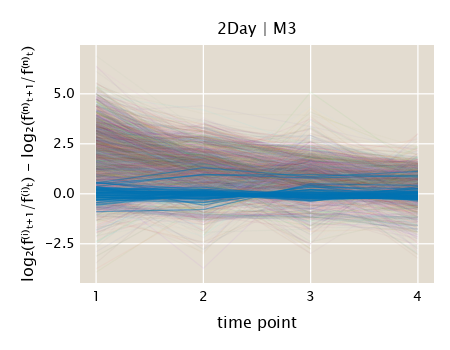

In [19]:
Random.seed!(42)

# Compute the mean population fitness s̄ₜ for all timepoints
data_st = DF.combine(
    DF.groupby(data_log[data_log.neutral, :], :time), :logf => DF.mean
)

# Locate index to extract the corresponding mean population fitness
idx_st = [findfirst(x .== data_st.time) for x in data_log.time]

# Add normalized column to dataframe
DF.insertcols!(
    data_log, :logf_norm => data_log.logf .- data_st[idx_st, :logf_mean]
)

# Initialize figure
fig = Figure(resolution=(450, 350))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="time point",
    ylabel="log₂(f⁽ⁱ⁾ₜ₊₁/f⁽ⁱ⁾ₜ) - log₂(f⁽ⁿ⁾ₜ₊₁/f⁽ⁿ⁾ₜ)",
    title="$(hub) | $(perturbation)"
)

# Define color palette
colors = ColorSchemes.glasbey_hv_n256

# group data by barcode
data_group = DF.groupby(data_log[.!data_log.neutral, :], :barcode)
# Loop through trajectories
for bc in data_group
    # Plot trajectory
    lines!(
        bc.logf_norm,
        color=(colors[StatsBase.sample(1:length(colors))], 0.05)
    )
end # for

# group neutral barcodes by barcode
data_group = DF.groupby(data_log[data_log.neutral, :], :barcode)
# Loop through trajectories
for bc in data_group
    # Plot trajectory
    lines!(
        bc.logf_norm,
        color=(ColorSchemes.seaborn_colorblind[1], 0.5)
    )
end # for

fig

We can see that indeed this normalization pulls the neutral lineages to have a
mean of zero, as expected. This subtracted quantity is the one we want to apply
our Bayesian inference over for this first stage of the model.

# Bayesian  model using `Turing.jl`

Our objective for this section will be to implement the Bayesian model using the
probabilistic programing language that `Turing.jl` encodes.

`[explanation here]`

Let's define the model using the @model macro from `Turing.jl`

In [51]:
Turing.@model function mean_fitness_neutrals(logf, t, σₛ, σₑ)
    # Define parameter types
    s̲ₜ = Float64[]
    σ̲ₜ = Float64[]

    ## Prior
    # Prior on the mean fitness
    s̲ₜ ~ Turing.filldist(Turing.Normal(0, σₛ), length(t))
    # Prior on error 
    σ̲ₜ ~ Turing.filldist(
        Turing.truncated(Turing.Normal(0, σₑ); lower=0.0), length(t)
    )
    
    ## Likelihood
    for i in eachindex(t)
        logf[:, i] ~ Turing.MvNormal(s̲ₜ, LinearAlgebra.I(length(t)) .* σ̲ₜ)
    end # for

    return logf
end # @model function

mean_fitness_neutrals (generic function with 2 methods)

Let's now extract the data.

In [54]:
# Define information for data to extract
# Define batch
batch = "Batch4"
hub = "2Day"
perturbation = "M3"
rep = "R1"

# Extract data. Note: The time T0 is common to all perturbations, thus, it must
# be extracted separately as a second condition.
data = df[
        (df.hub .== hub) .& 
        (df.batch .== batch) .&
        (
            (df.perturbation .== perturbation) .| 
            (df.perturbation .== "None")
        ) .&
        (
            (df.rep .== rep) .| 
            (df.rep .== "R0")
        )
    ,
:]

# Extract total counts per barcode
data_total = DF.combine(DF.groupby(data, :time), :count => sum)
# Extract total counts per barcode
data_total = DF.combine(DF.groupby(data, :time), :count => sum)
# Add total count column to dataframe
DF.leftjoin!(data, data_total; on=:time)
# Add frequency column
DF.insertcols!(data, :freq => data.count ./ data.count_sum)

# Initialize dataframe to save the log freq changes
data_log = DF.DataFrame()

# Group data by barcode
data_group = DF.groupby(data, :barcode)

# Loop through each group
for d in data_group
    # Compute log change
    DF.append!(
        data_log, 
        DF.DataFrame(
            :barcode .=> first(d.barcode),
            :time => d.time[2:end],
            :logf => diff(log2.(d.freq)),
            :neutral .=> first(d.neutral)
        )
    )
end # for

# Extract data
logf = hcat(
    [
        - DF.sort(d, :time).logf 
        for d in DF.groupby(data_log[data_log.neutral, :], :barcode)
    ]...
)

4×56 Matrix{Float64}:
 1.47366  1.34488  1.35058  1.22006  …  0.913891  1.66707  1.34959  1.27052
 2.06659  2.05905  2.07508  2.04364     1.03313   2.06083  1.84944  1.93266
 1.62974  1.85665  1.75181  1.74175     0.765761  1.82683  1.92585  1.82092
 1.75759  1.32945  1.46862  1.58213     0.612313  1.72753  1.73123  1.68068

Now, we are ready to test the model.

In [55]:
Random.seed!(42)

# Define model
model = mean_fitness_neutrals(logf, unique(data_log.time), 5.0, 1.0);

# Sample
# chain = Turing.sample(model, Turing.NUTS(0.65), 3000, progress=false);
chain = Turing.sample(
    model, Turing.NUTS(0.65), Turing.MCMCThreads(), 10000, 3, progress=false
)

# Print summary stats
Turing.summarystats(chain)

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/mrazo/.julia/packages/Turing/b6CoW/src/inference/hmc.jl:190
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/mrazo/.julia/packages/Turing/b6CoW/src/inference/hmc.jl:190
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /Users/mrazo/.julia/packages/Turing/b6CoW/src/inference/hmc.jl:190


Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

       s̲ₜ[1]    1.3430    0.1793     0.0010    0.0027   4903.5405    1.0004    ⋯
       s̲ₜ[2]    2.0618    0.0804     0.0005    0.0021   1520.8425    1.0016    ⋯
       s̲ₜ[3]    1.7383    0.1921     0.0011    0.0032   3236.8804    1.0015    ⋯
       s̲ₜ[4]    1.5210    0.2545     0.0015    0.0040   4031.8757    1.0003    ⋯
       σ̲ₜ[1]    0.1397    0.2398     0.0014    0.0032   5047.9425    1.0002    ⋯
       σ̲ₜ[2]    0.0207    0.1038     0.0006    0.0022   2317.2786    1.0008    ⋯
       σ̲ₜ[3]    0.1344    0.2428     0.0014    0.0034   4643.3954    1.0003    ⋯
       σ̲ₜ[4]    0.2479    0.3208     0.0019    0.0053   3920.5974    1.0008    ⋯
                                                                1 column omitted


That runs incredibly fast! Let's look at the traces for each of the walkers on
each parameter.

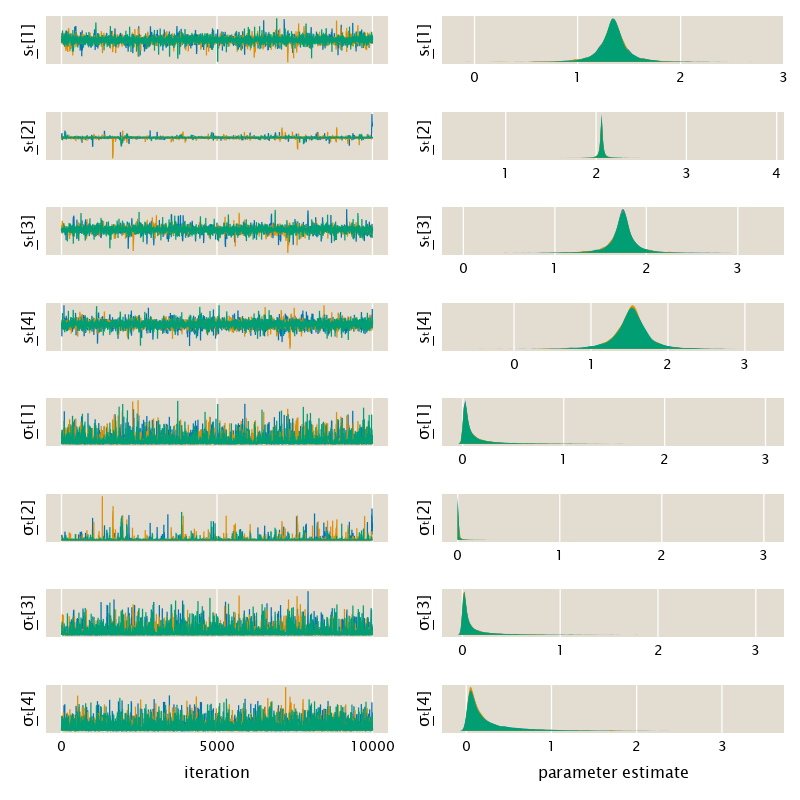

In [59]:
# Extract parameters
params = names(chain, :parameters)

# Extract number of chains
n_chains = length(MCMCChains.chains(chain))
# Extract number of parameters
n_samples = length(chain)

# Initialize figure
fig = Figure(resolution=(800, 800))

BayesFitness.viz.mcmc_trace_density!(fig, chain)

fig